# REVOLUTIONIZING SKINCARE WITH AI POWERED RECOMMENDATIONS FOR MELANIN RICH SKIN

![2d248f5507752726ddc2198b39071e4e](https://github.com/user-attachments/assets/9c7a2247-b758-4aee-8bc7-50fa0bf76f2d)


**GROUP MEMBERS**
1. Esther Cheruiyot
2. Brian Githinji
3. Grace Gitau 
4. Maureen Imanene

## PROJECT SUMMARY

To come back to...

## Business Problem
Black women represent a significant demographic in the beauty and skincare industry, yet they face limited access to skincare products tailored to their specific needs, such as hyper- pigmentation, dryness, and sensitivity. Most available recommendation systems overlook the unique skin concerns of Black women, offering general suggestions rather than targeted solutions. This gap impacts consumer satisfaction, as Black women often struggle to find effective products for their melanin-rich skin. 

This project aims to develop a recommendation system using advanced AI techniques to cater specifically to Black women’s skincare needs. By integrating machine learning, content- based filtering, collaborative filtering, and sentiment analysis, the system will offer personalized skincare recommendations. Leveraging skin_tone (Author's skin tone (e.g. fair, tan, etc.) as a classification feature, we aim to distinguish and target products that align with melanin-rich skin concerns.

## Objectives
1. Develop a melanin-centered skincare recommendation system using deep learning, tailored for Black women’s unique skin needs. 2. Utilize content-based and collaborative filtering along with sentiment analysis to enhance recommendation accuracy. 
3. Deploy an accessible Streamlit interface for personalized, user-friendly skincare suggestions. 
4. Integrate Logistic Regression, SVD, and K-means clustering to improve recommendation precision.

## Stakeholders
1. *Users*: Black women seeking tailored skincare solutions. 
2. *Skincare Brands*: Companies interested in product insights for melanin-rich skin. 
3. *Healthcare Professionals*: Dermatologists who may use the system as a recommendation tool. 
4. *AI and Skincare Researchers*: Those exploring AI applications in skincare for under- represented groups.

## Data Understanding:
The dataset was collected via a Python scraper and contains:
- Product Information: Over 8,000 beauty products from the Sephora online store, including product and brand names, prices, ingredients, ratings, and various features. 
- User Reviews: Approximately 1 million reviews across over 2,000 products in the skincare category. These reviews include user appearances, skin types, and review ratings.

The key features include:
- Product Features: `product_id`, `product_name`, `brand_name`, `ingredients`, `rating`, `price_ksh`, `new`, `out_of_stock`, `highlights`. 
- Review Features: `author_id`, `rating`, `review_text`, `skin_type`, `skin_tone`, and
`helpfulness`.

### STEP 1: DATA LOADING

In [ ]:
pip install wordcloud


In [ ]:
pip install tensorflow


In [28]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # To visualize text data
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, precision_score, recall_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


import pickle

In [3]:
# Load the product info and skincare products reviews from Excel files
products = pd.read_csv('data/product_info.xls', encoding = "ISO-8859-1")
reviews = pd.read_csv('data/skincare_products_reviews.xls', encoding = "ISO-8859-1", low_memory=False)

print('Products size:', products.shape)
print('Reviews size:', reviews.shape)

Products size: (8494, 27)
Reviews size: (49977, 19)


In [4]:
# Necessary columns for target analysis
product_columns = [
    'product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 
    'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 
    'ingredients', 'price_usd', 'new', 'out_of_stock', 'highlights', 'primary_category', 
    'secondary_category', 'tertiary_category', 'sephora_exclusive'
]

review_columns = [
    'product_id', 'author_id', 'rating', 'is_recommended', 'helpfulness', 
    'review_text', 'skin_tone', 'skin_type', 'eye_color', 'hair_color', 'submission_time'
]

# Filter columns in each dataset
products_filtered = products[product_columns]
reviews_filtered = reviews[review_columns]

# Merge filtered dataframes on 'product_id'
data = pd.merge(products_filtered, reviews_filtered, on='product_id', how='inner')

# Display merged data info and preview
data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,author_id,rating_y,is_recommended,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time
0,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,6921691467,5,1.0,1.000000,This product is amazing. Makes my skin feel so...,NaN,dry,hazel,blonde,2023-01-02
1,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,40727014792,5,1.0,0.833333,I pair this with the algae niacinamide moistur...,NaN,combination,blue,blonde,2022-11-06
2,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,7186952566,5,1.0,0.625000,Definitely my favorite I use it for under eye ...,NaN,NaN,NaN,NaN,2022-10-05
3,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,2117812169,5,1.0,1.000000,I bought this with the toner as I was looking ...,light,combination,green,brown,2022-09-15
4,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,12538328524,5,1.0,0.888889,Been using for months now. I went in and asked...,fair,NaN,NaN,NaN,2022-06-02


### STEP 2: DATA PRE-PROCESSING

In [5]:
# Checking for duplicates
data.duplicated().sum()

0

In [6]:
# Handling missing values
missing = []
unique = []
types = []
variables = []
count = []

for item in data.columns:
    variables.append(item)
    missing.append(data[item].isnull().sum())
    unique.append(data[item].nunique())
    types.append(data[item].dtypes)
    count.append(len(data[item]))
    
output = pd.DataFrame({
    'variable': variables, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
   
})
print("Data info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)

Data info : 


,variable,dtype,count,unique,missing
0,variation_desc,object,49977,5,49585
1,helpfulness,float64,49977,1209,13455
2,highlights,object,49977,750,11513
3,variation_value,object,49977,283,10338
4,variation_type,object,49977,5,9052
5,hair_color,object,49977,7,8851
6,size,object,49977,280,8615
7,skin_tone,object,49977,14,7201
8,tertiary_category,object,49977,29,6996
9,eye_color,object,49977,6,6260


In [7]:
# Define threshold for missing values (e.g., 50%)
threshold = 0.5

# Calculate the percentage of missing values for each column
output['missing_percentage'] = output['missing'] / output['count']

# List columns with missing values above the threshold
columns_to_drop = output[output['missing_percentage'] > threshold]['variable'].tolist()

# Drop these columns from the data
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print("Dropped columns with over 50% missing values:", columns_to_drop)

Dropped columns with over 50% missing values: ['variation_desc']


In [8]:
# Drop rows with missing values
data.dropna(axis=0,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16060 entries, 3 to 49969
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          16060 non-null  object 
 1   product_name        16060 non-null  object 
 2   brand_id            16060 non-null  int64  
 3   brand_name          16060 non-null  object 
 4   loves_count         16060 non-null  int64  
 5   rating_x            16060 non-null  float64
 6   reviews             16060 non-null  float64
 7   size                16060 non-null  object 
 8   variation_type      16060 non-null  object 
 9   variation_value     16060 non-null  object 
 10  ingredients         16060 non-null  object 
 11  price_usd           16060 non-null  float64
 12  new                 16060 non-null  int64  
 13  out_of_stock        16060 non-null  int64  
 14  highlights          16060 non-null  object 
 15  primary_category    16060 non-null  object 
 16  secondary

In [9]:
data.shape

(16060, 29)

In [10]:
# Basic Statistical Overview
data.describe()

,brand_id,loves_count,rating_x,reviews,price_usd,new,out_of_stock,sephora_exclusive,rating_y,is_recommended,helpfulness
count,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000,16060.000000
mean,5894.136426,9793.330635,4.203908,75.435679,61.749730,0.039228,0.055044,0.297073,4.140847,0.786800,0.773630
std,1377.326239,8030.100198,0.440261,36.497593,58.752432,0.194143,0.228072,0.456983,1.307110,0.409581,0.299565
min,1073.000000,0.000000,1.846200,1.000000,3.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5946.000000,3993.000000,3.963400,46.000000,28.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.666667
50%,6272.000000,7740.000000,4.255100,75.000000,43.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.900000
75%,6357.000000,12520.000000,4.538500,105.000000,73.000000,0.000000,0.000000,1.000000,5.000000,1.000000,1.000000
max,8017.000000,43971.000000,5.000000,139.000000,400.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000


Creating a new 'skin_tone_category' column to classify skin tones as 'light' or 'dark'. By grouping skin tones into 'light' and 'dark,' we can focus our analysis and modeling efforts on characteristics most relevant to our target audience, ensuring more accurate and personalized recommendations for melanated skin types.

In [11]:
unique_skin_tones = data['skin_tone'].unique()
print(unique_skin_tones)

['light' 'fair' 'lightMedium' 'mediumTan' 'fairLight' 'medium' 'rich'
 'deep' 'tan' 'dark' 'porcelain' 'olive']


In [12]:
# Lists of skin tones categorized as 'light' or 'dark'
light_skin_tones = ['light', 'fair', 'lightMedium', 'fairLight', 'porcelain', 'olive']
dark_skin_tones = ['mediumTan', 'medium', 'tan', 'rich', 'deep', 'dark']

# Creating a new column 'skin_tone_category' with 'light' and 'dark' values
data['skin_tone_category'] = data['skin_tone'].apply(lambda x: 'non-melanated' if x in light_skin_tones else 'melanated' if x in dark_skin_tones else 'other')

# Convert 'submission_time' to datetime format
data['submission_time'] = pd.to_datetime(data['submission_time'], errors='coerce')

# Normalize Prices
data['price_ksh'] = (data['price_usd'] * 129.27)

In [13]:
data.shape

(16060, 31)

**TEXT CLEANING STEPS:**
1.  Converting the text to lowercase to ensure uniformity.
2.  Removing square bracket enclosed content to eliminate unnecessary elements.
3.  Eliminating URLs (both http and www) to enhance readability.
4.  Removing HTML tags to strip away any formatting artifacts.
5.  Eliminating punctuation marks to focus solely on textual content.
6.  Removing newline characters to maintain consistency in formatting.
7.  Eliminating alphanumeric words to streamline the dataset.
8.  Tokenizing the text using spaces to facilitate further processing.
9.  Removing stop words to reduce noise in the dataset.
10.  Employing stemming to reduce words to their root form, aiding in simplification.
11.  Joining the cleaned words back into a cohesive string to prepare for subsequent analysis.
12.  Returning the cleaned text, now deemed suitable for further processing

In [29]:
# Text cleaning function [review_text]

# Initialize the stemmer
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()  # Step 1
    text = re.sub(r'\[.*?\]', '', text)  # Step 2
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Step 3
    text = re.sub(r'<.*?>', '', text)  # Step 4
    text = re.sub(r'[^\w\s]', '', text)  # Step 5
    text = re.sub(r'\n', ' ', text)  # Step 6
    text = re.sub(r'\b\w*\d\w*\b', '', text)  # Step 7
    tokens = text.split()  # Step 8

    # Step 9: Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Step 10: Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Step 11: Join tokens
    return ' '.join(tokens)

# Apply the cleaning function to the review_text column
data['review_text'] = data['review_text'].apply(clean_text)

**Size:** Standardizing units and handling any variations or inconsistencies.

- Converting values to a consistent unit, milliliters.
- Extracting numerical values to handle as continuous data for modeling if needed.

**Ingredients:** Leaving ingredients raw preserves essential chemical terms for analysis. This enables targeted NLP methods, like TF-IDF, to identify key ingredients and supports ingredient-based recommendations. This approach maintains data integrity for future modeling without altering original content.

In [14]:
# Text cleaning function [Size]

# Standardize 'size' column
# Example: extract numerical part and units, e.g., '50 ml' to 50 and 'ml'
def clean_size(size):
    if pd.isna(size):
        return None
    size = size.lower()
    match = re.match(r'(\d+(\.\d+)?)\s?(ml|oz|g|grams|ounces)?', size)
    if match:
        value, _, unit = match.groups()
        # Convert to a consistent unit, e.g., convert oz to ml
        if unit in ['oz', 'ounces']:
            return float(value) * 29.5735  # Convert ounces to milliliters
        elif unit in ['g', 'grams']:
            return float(value)  # Keeping grams as is
        else:
            return float(value)  # If it's ml or unspecified, assume ml
    return None

data['size_ml'] = data['size'].apply(clean_size)
data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time,skin_tone_category,price_ksh,size_ml
3,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,1.000000,I bought this with the toner as I was looking ...,light,combination,green,brown,2022-09-15,non-melanated,7497.66,39.924225
5,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,0.833333,"When this product was recommended to me, I was...",fair,combination,brown,blonde,2021-11-18,non-melanated,7497.66,39.924225
8,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,0.777778,this is my first ever purchase from algenist a...,light,oily,brown,black,2021-07-30,non-melanated,7497.66,39.924225
9,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,1.000000,When stressed skin starts to burn this seems t...,light,dry,blue,brown,2021-05-17,non-melanated,7497.66,39.924225
10,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,1.000000,Sample was sitting in my drawer for months bef...,fair,combination,blue,blonde,2021-05-10,non-melanated,7497.66,39.924225


### STEP 3: EXPLORATORY DATA ANALYSIS (EDA)

#### UNIVARIATE ANALYSIS

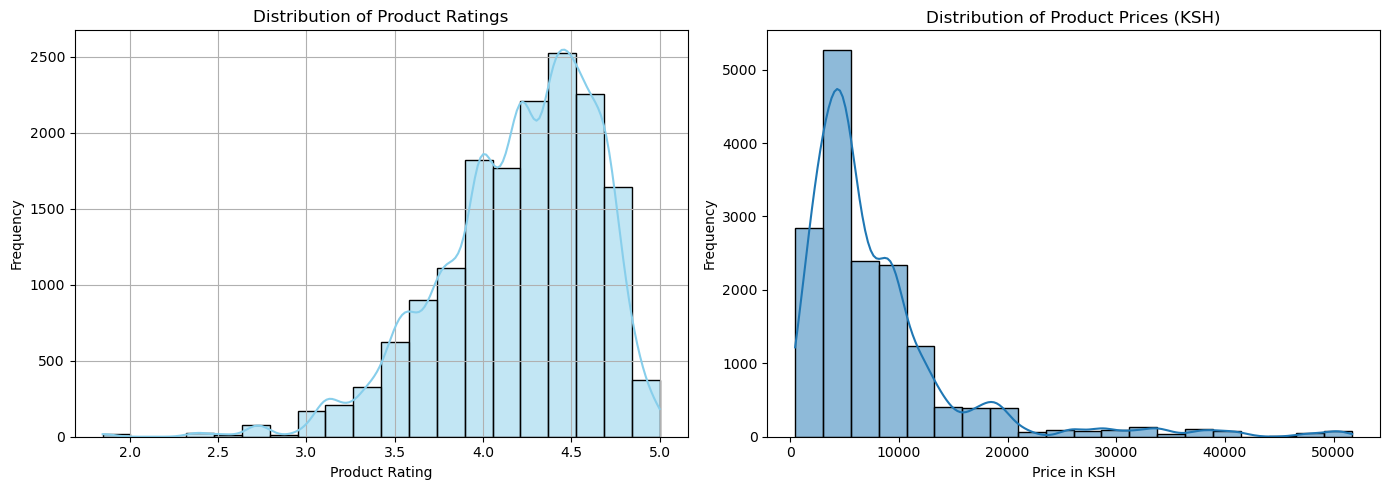

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Visualizing Distribution of Ratings
sns.histplot(data['rating_x'], bins=20, kde=True, color='skyblue', ax=ax1)
ax1.set_title('Distribution of Product Ratings')
ax1.set_xlabel('Product Rating')
ax1.set_ylabel('Frequency')
ax1.grid()

# Price Distribution
sns.histplot(data['price_ksh'], bins=20, kde=True, ax=ax2)
ax2.set_title('Distribution of Product Prices (KSH)')
ax2.set_xlabel('Price in KSH')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Histogram 1: Most products seem to have higher ratings, indicating a general satisfaction among customers. The peak around the highest rating suggests that products on this platform are generally well-received, though a minority of products still receive lower scores. This distribution helps set expectations for the customer satisfaction range across products.

Histogram 2: The majority of products fall within a low-to-mid price range, suggesting affordability options across the market. This concentration can aid in identifying budget-friendly options for skincare that may appeal to diverse skin tones.

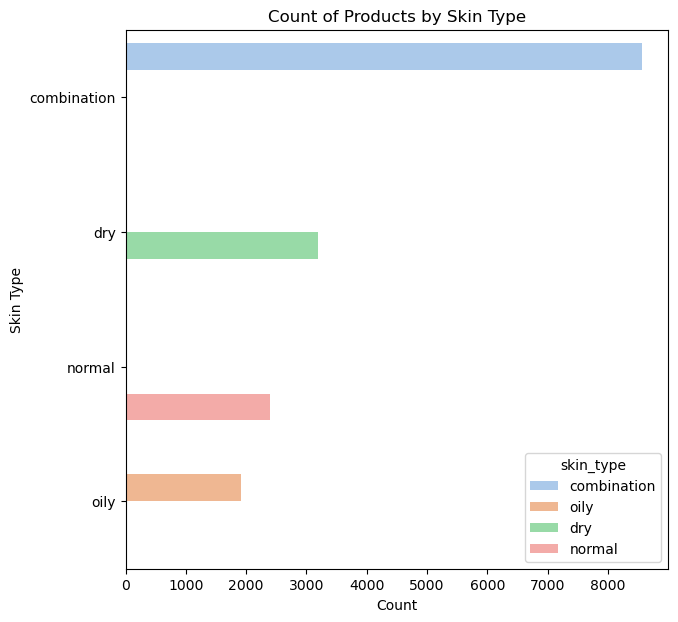

In [15]:
# Count of Products by Skin Type
plt.figure(figsize=(7, 7))
sns.countplot(y='skin_type', data=data, order=data['skin_type'].value_counts().index, palette='pastel', hue='skin_type')
plt.title('Count of Products by Skin Type')
plt.xlabel('Count')
plt.ylabel('Skin Type')
plt.show()

The distribution shows that products labeled for combination skin are the most common, followed by those for dry, normal, and then oily skin. This insight can guide product selection based on prevalent skin types and consumer demand within the Black women demographic.

#### BIVARIATE ANALYSIS

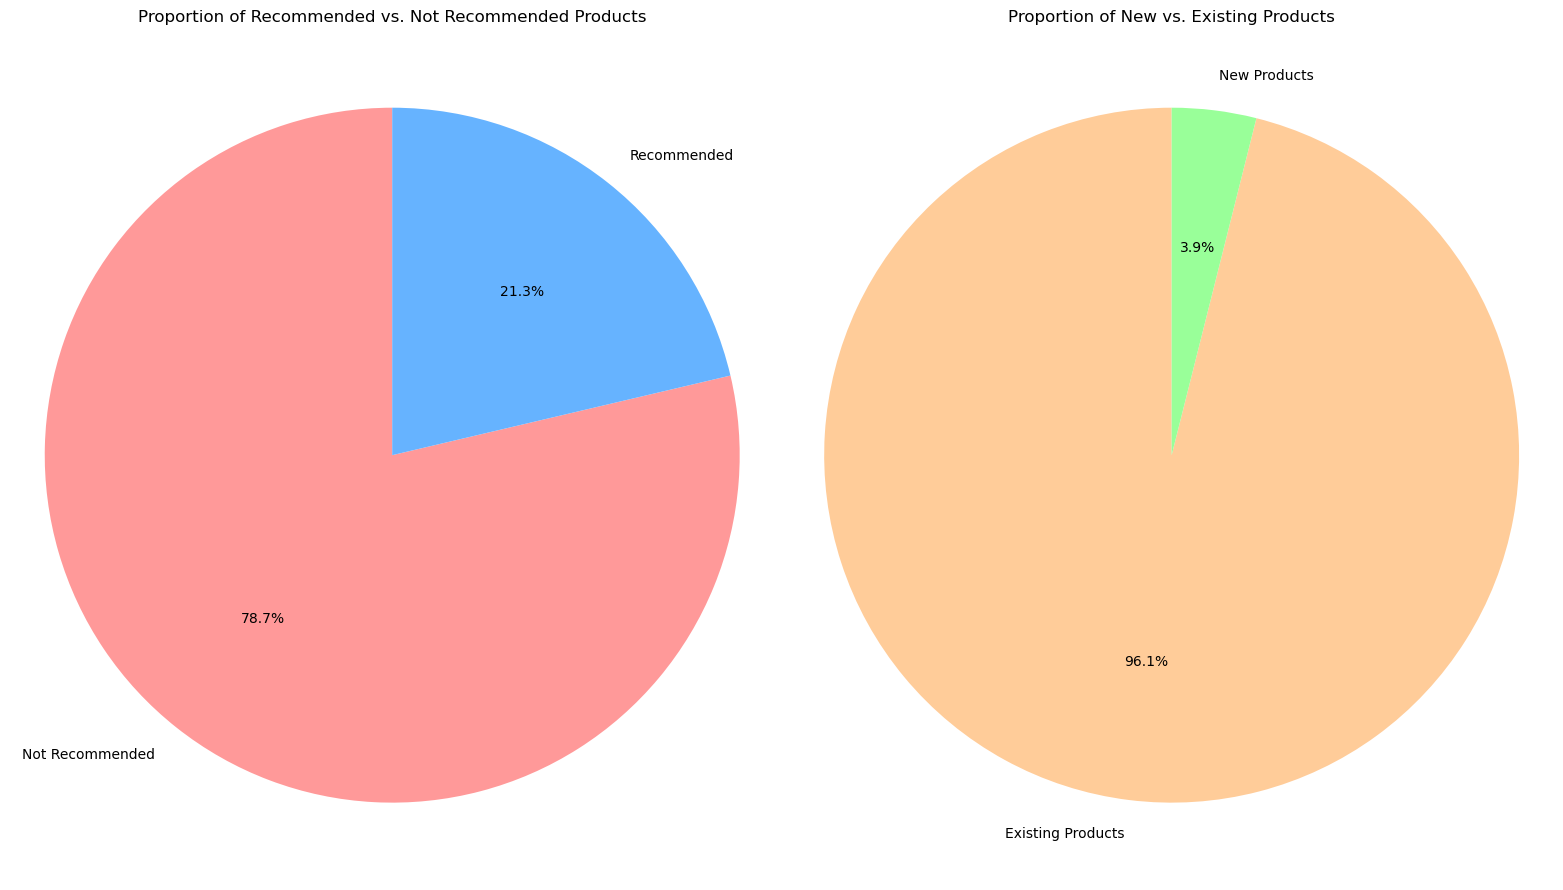

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))

# Pie chart for Recommended vs Not Recommended
recommendation_counts = data['is_recommended'].value_counts()
ax1.pie(recommendation_counts, labels=['Not Recommended', 'Recommended'], autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B3FF'])
ax1.set_title('Proportion of Recommended vs. Not Recommended Products')
ax1.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Pie chart for New vs Existing Products
new_counts = data['new'].value_counts()
ax2.pie(new_counts, labels=['Existing Products', 'New Products'], autopct='%1.1f%%', startangle=90, colors=['#FFCC99', '#99FF99'])
ax2.set_title('Proportion of New vs. Existing Products')
ax2.axis('equal')

plt.tight_layout()
plt.show()

The **Recommended** pie chart illustrates the percentage of products recommended versus those that are not. A significant portion (80.3%) of products are not marked as recommended, indicating a possible quality or suitability gap. This could help identify where product performance might fall short or suggest a need for more tailored product options.

The **Products** pie chart shows the balance between new and existing products. The larger percentage of existing products (96.3%) suggests that the platform maintains a consistent range of products, with newer items being introduced selectively. This distribution can provide insights into the inventory management and refresh rates of the catalog over time.

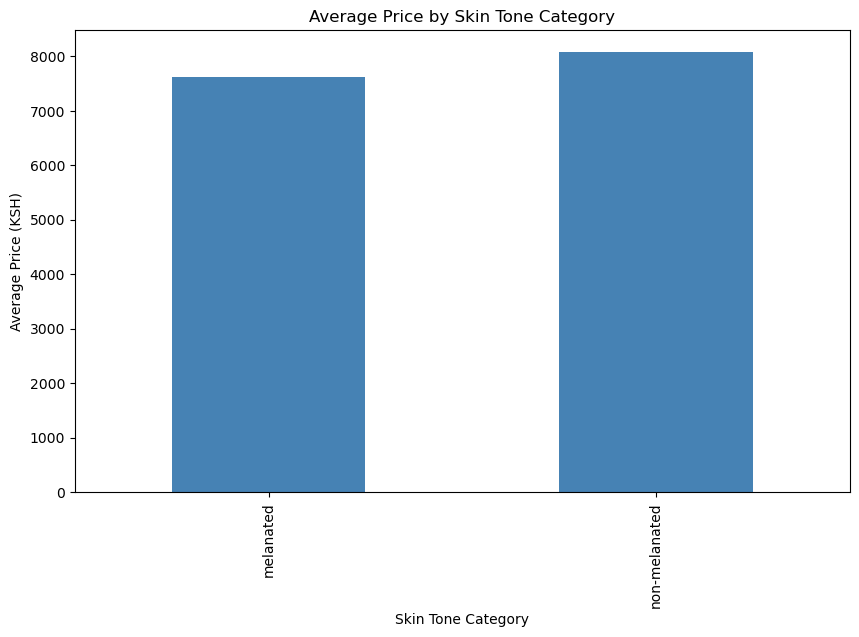

In [33]:
# Average Price by Skin Tone
avg_price_skin_tone = data.groupby('skin_tone_category')['price_ksh'].mean().sort_values()
plt.figure(figsize=(10, 6))
avg_price_skin_tone.plot(kind='bar', color='steelblue')
plt.title('Average Price by Skin Tone Category')
plt.xlabel('Skin Tone Category')
plt.ylabel('Average Price (KSH)')
plt.show()

There is a noticeable price difference across skin tones. Products for melanated skin tend to have lower average prices, than non-melanated skin tones, highlighting more affordable options specifically formulated or suited for melanated skin. 

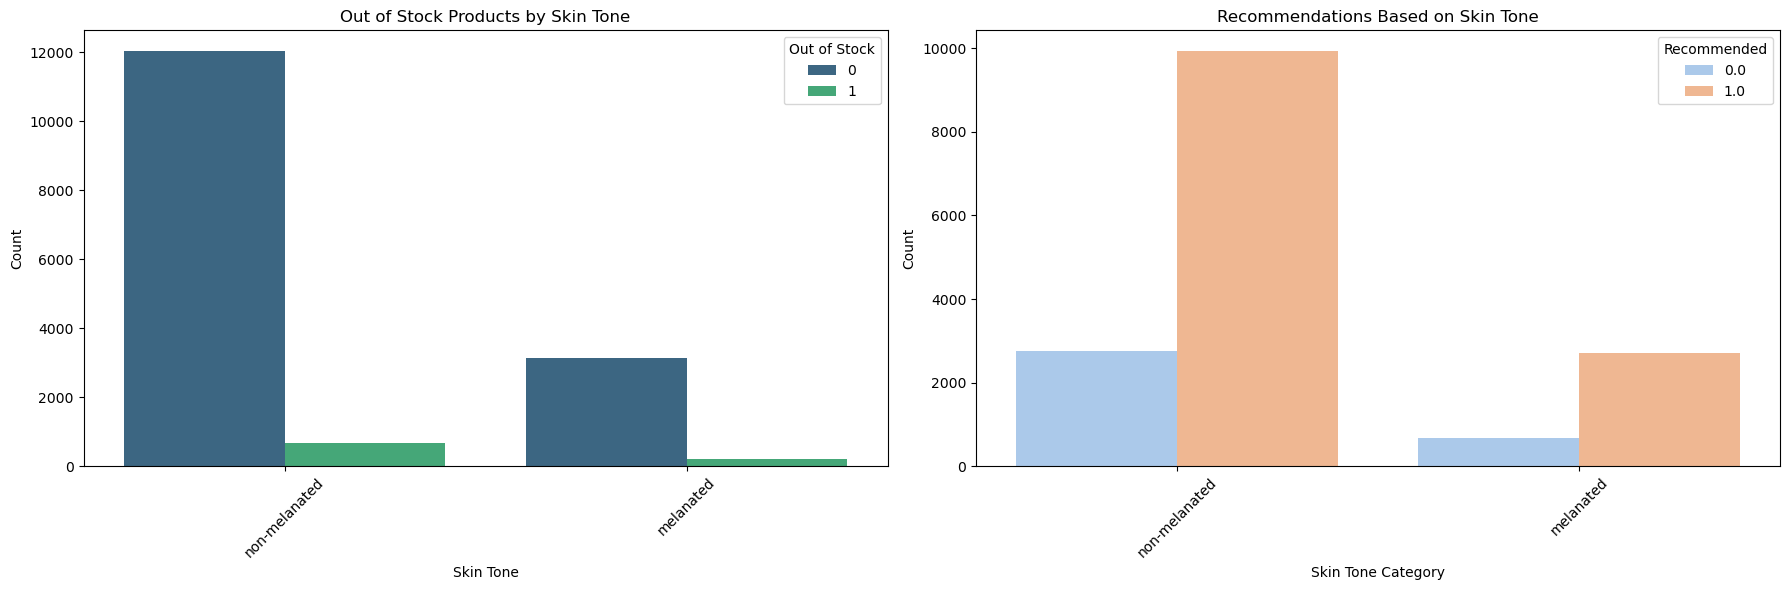

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Out of Stock by Skin Tone
sns.countplot(x='skin_tone_category', hue='out_of_stock', data=data, palette='viridis', ax=ax1)
ax1.set_title('Out of Stock Products by Skin Tone')
ax1.set_xlabel('Skin Tone')
ax1.set_ylabel('Count')
ax1.legend(title='Out of Stock')
ax1.tick_params(axis='x', rotation=45)

# Recommendations by Skin Tone
sns.countplot(x='skin_tone_category', hue='is_recommended', data=data, palette='pastel', ax=ax2)
ax2.set_title('Recommendations Based on Skin Tone')
ax2.set_xlabel('Skin Tone Category')
ax2.set_ylabel('Count')
ax2.legend(title='Recommended')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Lighter skin tones show a higher count of both in-stock and out-of-stock products. This contrasts with deep skin tones which have fewer options overall and lower in-stock counts. This discrepancy might indicate a supply gap for these deeper skin tones, which are more likely to face limited product availability.

Products targeting melanated skin tones receive fewer recommendations, suggesting that product options may not fully address the needs or preferences of these individuals.

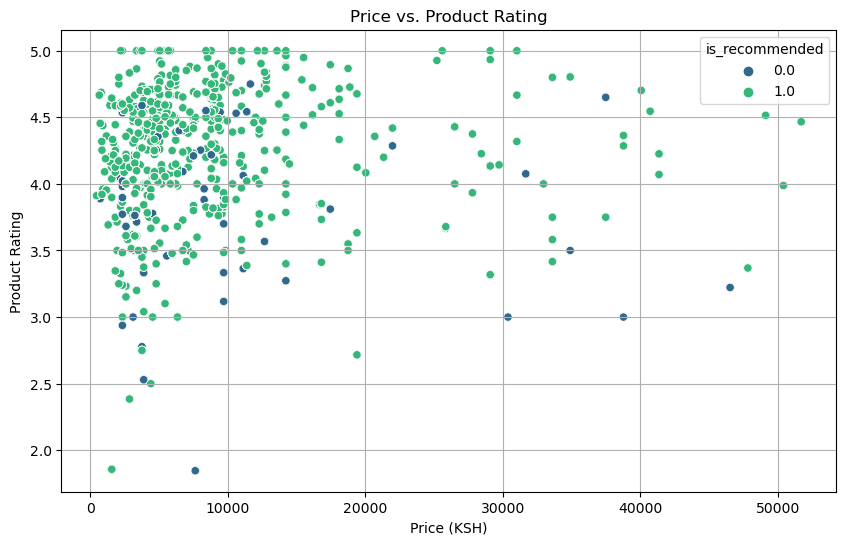

In [35]:
# Correlation between Ratings and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='price_ksh', y='rating_x', hue='is_recommended', palette='viridis')
plt.title('Price vs. Product Rating')
plt.xlabel('Price (KSH)')
plt.ylabel('Product Rating')
plt.grid()
plt.show()

The scatter plot shows the relationship between product price and customer ratings. Although there is no strong correlation, products in the low-to-mid price range tend to receive favorable ratings, suggesting that affordability does not necessarily compromise quality. This insight may encourage users to explore budget-friendly options without sacrificing product satisfaction.

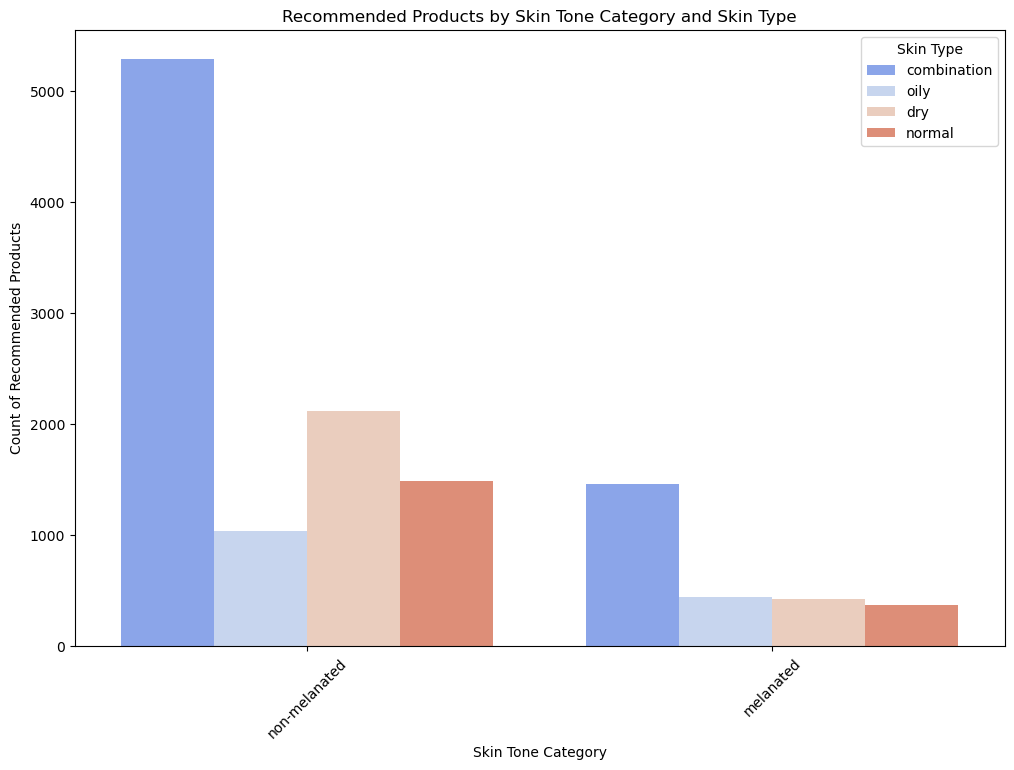

In [36]:
# Count of Recommended Products by Skin Tone and Skin Type
plt.figure(figsize=(12, 8))
sns.countplot(x='skin_tone_category', hue='skin_type', data=data[data['is_recommended'] == 1], palette='coolwarm')
plt.title('Recommended Products by Skin Tone Category and Skin Type')
plt.xlabel('Skin Tone Category')
plt.ylabel('Count of Recommended Products')
plt.xticks(rotation=45)
plt.legend(title='Skin Type')
plt.show()

There are more recommended product options for combination and dry skin types across lighter skin tones. This trend highlights a potential focus on lighter tones in product recommendations, which may overlook the unique needs of Black women with deeper skin tones and varied skin types.

#### MULTIVARIATE ANALYSIS

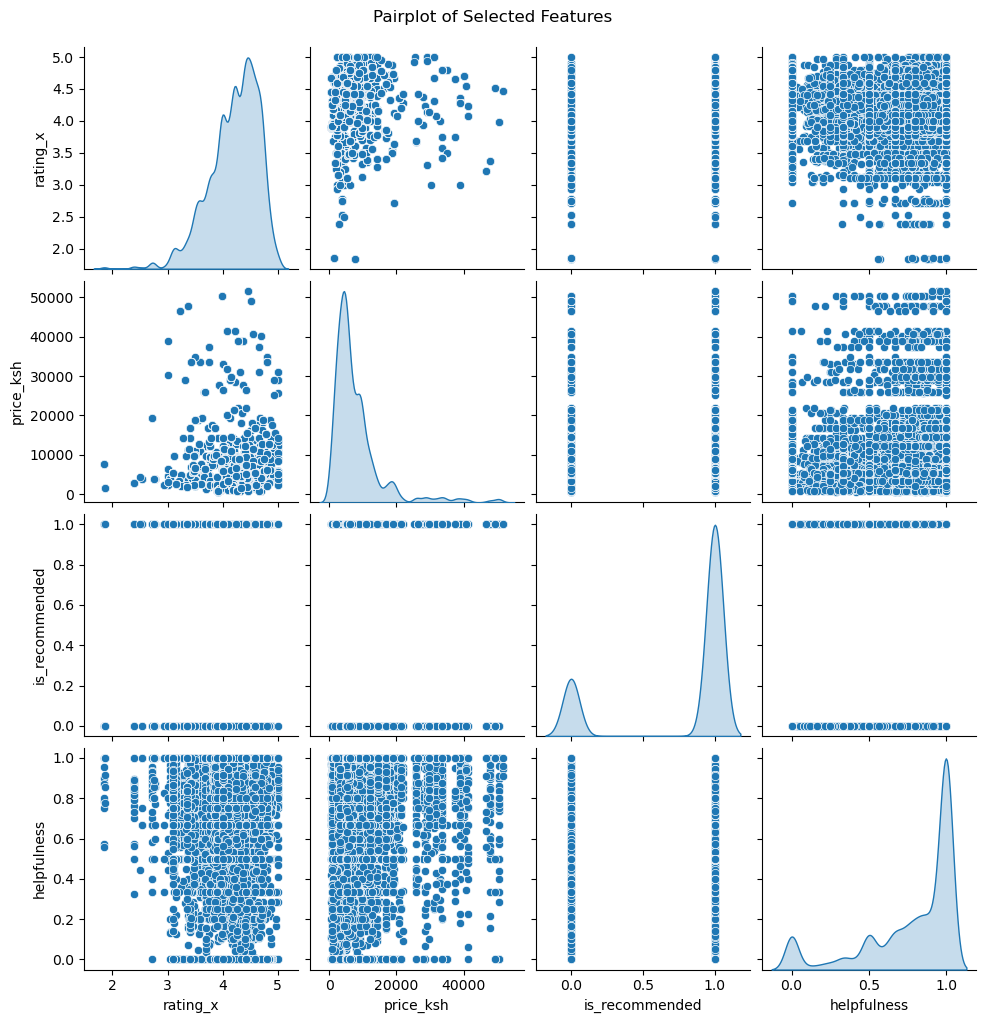

In [37]:
# Pairplot for Selected Features
selected_features = ['rating_x', 'price_ksh', 'is_recommended', 'helpfulness']
sns.pairplot(data[selected_features], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()

The pair plot examines relationships between selected numeric features, such as rating, price(Ksh), and helpfulness. The absence of clear patterns in most pairwise relationships suggests limited linear correlation among these variables. However, this view offers insight into the variability and potential interactions within the data, aiding in feature selection and engineering for subsequent modeling.

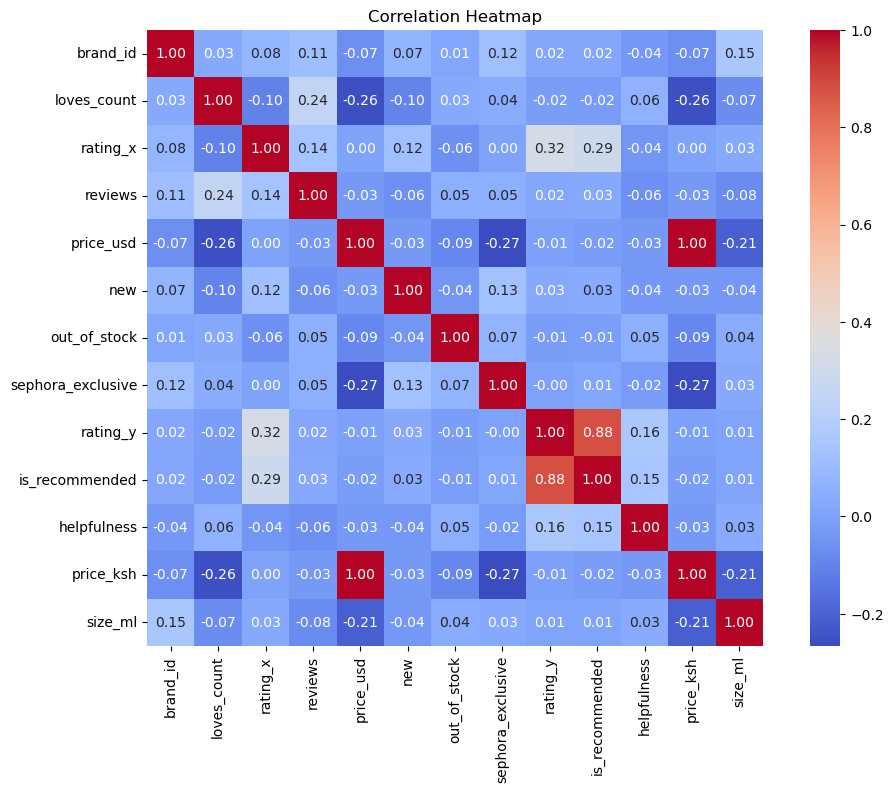

In [38]:
# Heatmap of Correlation Between Numeric Features
plt.figure(figsize=(12, 8))

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Calculate correlation only on numeric columns
correlation = numeric_data.corr()

# Create the heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows weak to moderate correlations between numeric features, with notable clusters indicating relationships. 

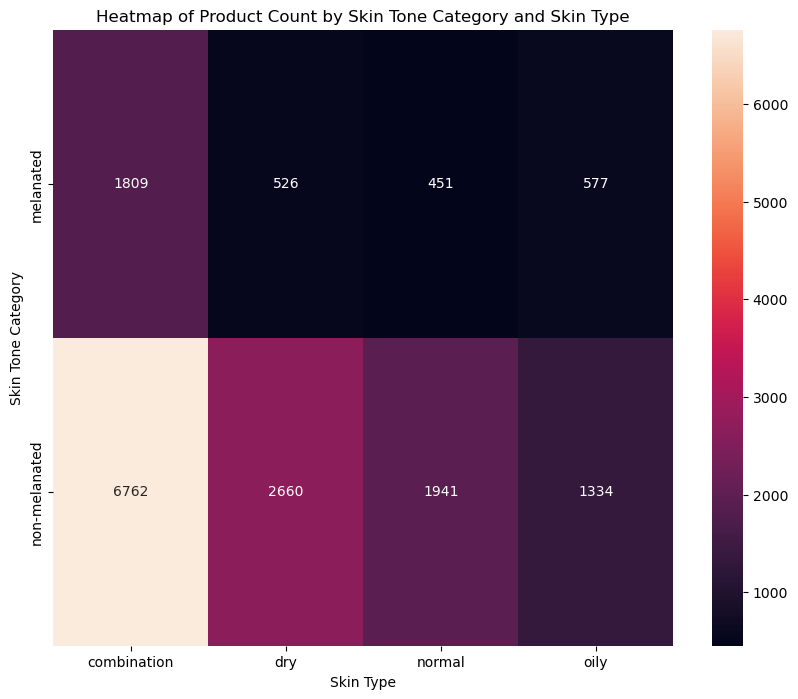

In [39]:
# Create a contingency table
contingency_table = pd.crosstab(index=data['skin_tone_category'], columns=data['skin_type'])
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title('Heatmap of Product Count by Skin Tone Category and Skin Type')
plt.xlabel('Skin Type')
plt.ylabel('Skin Tone Category')
plt.show()

The heatmap analysis of `skin_type` and `skin_tone_category` highlights important insights that align closely with our objective of providing tailored skincare recommendations for Black women. Our data reveals a concentration of products available for combination and dry skin types, particularly within lighter skin tones. However, there is a notable scarcity of options for deeper skin tones, suggesting that Black women may have fewer product options specifically suited to their needs. This gap underscores the limited market focus on skincare for melanin-rich skin concerns, such as hyperpigmentation, dryness, and sensitivity, which are often more pronounced in deeper skin tones.

These findings directly support our business problem: many existing recommendation systems fail to provide targeted solutions for Black women. The evident lack of specialized options for drier skin in deeper tones emphasizes an opportunity to develop and recommend products that address this unique need. By prioritizing these underserved areas, our recommendation system can significantly enhance satisfaction and efficacy for Black women seeking products that work for their melanin-rich skin.

### STEP 4: NLP

In [16]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [15]:
# Text cleaning function [review_text]

# Initialize the stemmer
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()  # Step 1
    text = re.sub(r'\[.*?\]', '', text)  # Step 2
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Step 3
    text = re.sub(r'<.*?>', '', text)  # Step 4
    text = re.sub(r'[^\w\s]', '', text)  # Step 5
    text = re.sub(r'\n', ' ', text)  # Step 6
    text = re.sub(r'\b\w*\d\w*\b', '', text)  # Step 7
    tokens = text.split()  # Step 8

    # Step 9: Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Step 10: Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Step 11: Join tokens
    return ' '.join(tokens)

# Apply the cleaning function to the review_text column
data['review_text'] = data['review_text'].apply(clean_text)

In [16]:
# Filter the DataFrame for melanated skin tones
melanated_data = data[data['skin_tone_category'] == 'melanated']


In [17]:

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
melanated_data['sentiment_scores'] = melanated_data['review_text'].apply(lambda x: sia.polarity_scores(x))
melanated_data['compound'] = melanated_data['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])


sentiment
positive    2955
neutral      228
negative     180
Name: count, dtype: int64


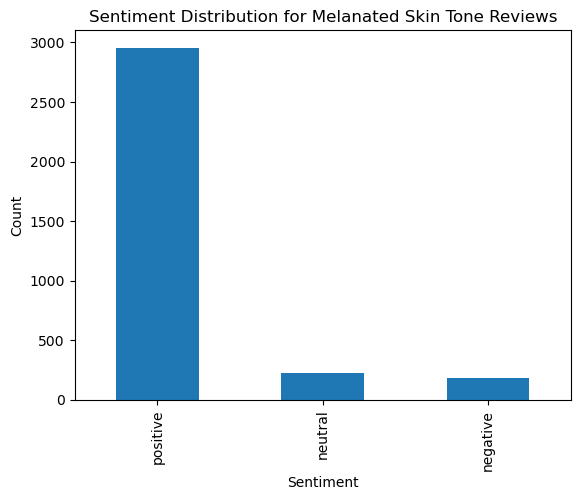

In [18]:
# Count the sentiment labels based on the compound score
melanated_data['sentiment'] = melanated_data['compound'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

# Count sentiment distribution
sentiment_counts = melanated_data['sentiment'].value_counts()
print(sentiment_counts)

# Visualize the sentiment distribution
import matplotlib.pyplot as plt

sentiment_counts.plot(kind='bar')
plt.title('Sentiment Distribution for Melanated Skin Tone Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


* We have performed sentiment analysis and obtained labels (positive, negative, neutral) for the melanated skin tone category. Now we proceed to build a model to predict sentiments based on the review texts.

In [19]:
# Convering labels to numerical format
# Encode sentiment labels
label_encoder = LabelEncoder()
melanated_data['sentiment_encoded'] = label_encoder.fit_transform(melanated_data['sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    melanated_data['review_text'], 
    melanated_data['sentiment_encoded'], 
    test_size=0.2, 
    random_state=42
)


In [26]:
classes = label_encoder.classes_
print(dict(enumerate(classes)))

{0: 'negative', 1: 'neutral', 2: 'positive'}


In [21]:
# Text Vectorization

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [22]:
# Training a Baseline Model - Random Forest Classifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators

# Fit the model
rf_classifier.fit(X_train_tfidf, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 0.8975
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        34
           1       1.00      0.10      0.18        41
           2       0.90      1.00      0.95       598

    accuracy                           0.90       673
   macro avg       0.97      0.39      0.41       673
weighted avg       0.91      0.90      0.86       673



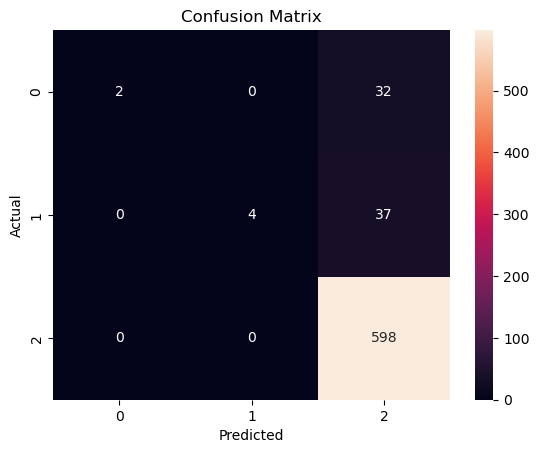

In [23]:
# Evaluating the Model

# Make predictions
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_mat, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


* Model Strengths: The Random Forest model demonstrates a robust ability to classify positive sentiment (Class 2) effectively, achieving high precision, recall, and F1-scores for this class.

* Model Weaknesses: There is a pronounced weakness in the model’s ability to classify negative (Class 0) and neutral (Class 1) sentiments, as indicated by the low recall and F1-scores for these classes. This suggests that the model is biased towards predicting positive sentiment, likely due to class imbalance in the dataset.


##### Addressing class imbalance with hyperparameter tuning

In [24]:
# Hyperparameter Tuning using Gridsearch

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [25]:
# Final Evaluation
best_rf_classifier = grid_search.best_estimator_
y_pred_best = best_rf_classifier.predict(X_test_tfidf)

# Accuracy and classification report for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best:.4f}')
print(classification_report(y_test, y_pred_best))


Best Model Accuracy: 0.8960
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        34
           1       1.00      0.07      0.14        41
           2       0.90      1.00      0.94       598

    accuracy                           0.90       673
   macro avg       0.97      0.38      0.40       673
weighted avg       0.91      0.90      0.85       673



* From the evaluation above we still note a class imbalance with our model poorly predicting the negative and neutral sentiments.

In [34]:
# Deep Learning Model
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews)
X_sequences = tokenizer.texts_to_sequences(reviews)


In [35]:
# Padding

max_length = 100  # Adjust based on your data
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')


In [37]:
# Labeling

y_encoded = to_categorical(melanated_data['sentiment_encoded'])


In [38]:
# Building the deep learning model

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding
embedding_dim = 100  # You can adjust this

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))  # Adjust the number of classes


In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Training the model
# Fit the model
#history = model.fit(X_padded, y_encoded, epochs=10, batch_size=32, validation_split=0.2)
#from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

#history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))




### STEP 5: MODELING

Our recommendation system can enhance satisfaction and efficacy for Black women by using data-driven insights from the heatmap to spotlight and prioritize products that meet specific, underserved needs. For instance, with the observed lack of options for dry skin in deeper skin tones, our system can recommend products designed to address hydration and moisture retention, which are critical for managing dryness in melanin-rich skin. Additionally, by identifying gaps for specific skin tones and types, we can curate products with ingredients that target common issues like hyperpigmentation or sensitivity—problems particularly relevant to Black women.

Through advanced filtering, collaborative filtering, and sentiment analysis, our system can highlight well-rated products that align with these needs, even if they’re currently under-marketed for Black women. By promoting these options and analyzing user feedback, the system can gradually refine and adjust recommendations, helping users find products that not only align with their skin type and tone but also actively address their unique skin concerns. This targeted approach leads to more effective skincare routines, as users are less likely to waste time or money on unsuitable products, ultimately increasing both satisfaction and loyalty to our recommendation platform.

### A. Content-Based Filtering Model
- We’ll start with a content-based filtering model using TF-IDF on ingredients and other product features.The aim is to recommend similar products based on ingredients and product features.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

# Preprocess the ingredients
data['ingredients'] = data['ingredients'].str.lower()

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the ingredients column to create the ingredients matrix
ingredients_matrix = tfidf.fit_transform(data['ingredients'])

# Check the ingredients matrix
print("Ingredients Matrix Shape:", ingredients_matrix.shape)


# Calculate Cosine Similarity for Products based on Ingredient features
cosine_sim = cosine_similarity(ingredients_matrix)

# Function to Recommend Products based on Content Similarity
def content_based_recommendations(product_id, top_n=5):
    idx = data.index[data['product_id'] == product_id].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    return data['product_name'].iloc[product_indices]

# Test Recommendation for a Sample Product
sample_product_id = data['product_id'].iloc[0]
print("Content-Based Recommendations:")
print(content_based_recommendations(sample_product_id))


Ingredients Matrix Shape: (16060, 2661)
Content-Based Recommendations:
5     GENIUS Collagen Calming Relief
8     GENIUS Collagen Calming Relief
9     GENIUS Collagen Calming Relief
10    GENIUS Collagen Calming Relief
11    GENIUS Collagen Calming Relief
Name: product_name, dtype: object


### B. Collaborative Filtering with SVD
- Now we’ll implement collaborative filtering using SVD to capture latent user-product interactions.The goal is to use Matrix Factorization (SVD) on the user-product interaction data for collaborative recommendations.

In [27]:
from sklearn.decomposition import TruncatedSVD

# Create User-Product Interaction Matrix
user_product_matrix = data.pivot_table(index='author_id', columns='product_id', values='rating_x').fillna(0)

# Apply SVD
svd = TruncatedSVD(n_components=20)
latent_matrix = svd.fit_transform(user_product_matrix)

# Recommending Top Products for a User
def collaborative_recommendations(user_id, top_n=5):
    user_index = data.index[data['author_id'] == user_id].tolist()[0]
    scores = latent_matrix[user_index].dot(latent_matrix.T)
    top_recommendations = scores.argsort()[-top_n:][::-1]
    return data['product_name'].iloc[top_recommendations]

# Test Recommendation for a Sample User
sample_user_id = data['author_id'].iloc[0]
print("Collaborative Filtering Recommendations:")
print(collaborative_recommendations(sample_user_id))


Collaborative Filtering Recommendations:
43739       Mineral Mattescreen Sunscreen SPF 40 PA+++
9807     Vitamin C Lactic Oil-Free Radiant Moisturizer
13846                     Honey Halo Moisturizer Jumbo
21125                        Express Ultra Dark Mousse
14817            FAB Pharma Calamine Pore Purging Mask
Name: product_name, dtype: object


### C. Sentiment Analysis on Review Text
- We'll use NLTK's Sentiment Intensity Analyzer for sentiment scoring on reviews.The goal being to analyze review_text for sentiment to refine recommendations based on positive feedback.

In [28]:
# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()
data['sentiment_score'] = data['review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Function to Recommend Products Based on Positive Sentiments
def sentiment_based_recommendations(user_id, top_n=5):
    user_reviews = data[data['author_id'] == user_id]
    positive_reviews = user_reviews[user_reviews['sentiment_score'] > 0.2]
    return positive_reviews['product_name'].head(top_n)

# Test Sentiment-Based Recommendation
print("Sentiment-Based Recommendations:")
print(sentiment_based_recommendations(sample_user_id))


Sentiment-Based Recommendations:
3    GENIUS Collagen Calming Relief
Name: product_name, dtype: object


#### Drop Unnecessary Columns
Now that we’ve vectorized ingredients and review_text, and extracted sentiment scores, we can drop these original columns

In [29]:
# Drop the original text columns
data = data.drop(columns=['ingredients', 'review_text'])


##### Preprocess the Data Completely
- Ensure all columns in X are numeric before applying any model. We’ve already converted most columns using TF-IDF, label encoding, and sentiment analysis.

In [30]:
# Check for remaining non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

# If there are any remaining non-numeric columns, consider encoding or removing them.


Non-numeric columns: Index(['product_id', 'product_name', 'size', 'variation_value', 'highlights',
       'author_id'],
      dtype='object')


In [31]:
# Drop unneeded columns
data = data.drop(columns=['product_id', 'author_id'])

# Apply TF-IDF on `product_name` and `highlights'
tfidf_product_name = TfidfVectorizer(max_features=50)
product_name_matrix = tfidf_product_name.fit_transform(data['product_name']).toarray()
product_name_df = pd.DataFrame(product_name_matrix, index=data.index)

tfidf_highlights = TfidfVectorizer(max_features=50)
highlights_matrix = tfidf_highlights.fit_transform(data['highlights']).toarray()
highlights_df = pd.DataFrame(highlights_matrix, index=data.index)

# Concatenate TF-IDF results and drop the original columns
data = pd.concat([data, product_name_df, highlights_df], axis=1)
data = data.drop(columns=['product_name', 'highlights'])

# Encode `size` and `variation_value` if needed
le_size = LabelEncoder()
data['size'] = le_size.fit_transform(data['size'])

le_variation_value = LabelEncoder()
data['variation_value'] = le_variation_value.fit_transform(data['variation_value'])


## Define and Training the base Model(Random Forest)

In [33]:
from sklearn.ensemble import RandomForestClassifier
# Define features (X) and target (y) -'is_recommended' is the target variable
X = data.drop(columns=['is_recommended'])
y = data['is_recommended']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert all column names to strings for both train and test sets
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Dropping datetime columns from training data
X_train = X_train.select_dtypes(exclude=['datetime64'])
X_test = X_test.select_dtypes(exclude=['datetime64'])

# Model Training
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict on test data
y_pred = classifier.predict(X_test)


#### Model Evaluation
Evaluate the model’s performance on the test set.

In [34]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Print classification report for more detailed evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       665
         1.0       0.97      0.97      0.97      2547

    accuracy                           0.95      3212
   macro avg       0.93      0.93      0.93      3212
weighted avg       0.95      0.95      0.95      3212



##### DEEP LEARNING .....to be continued

### STEP 6: FEATURE IMPORTANCE

### STEP 7: SAVING MODELS FOR DEPLOYMENT

### RECOMMENDATIONS